In [1]:
import os
import shutil

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report

In [3]:
class NaiveBayes:
    def __init__(self):
        self.features_prob_in_class_with_value = None
        self.classes_prob = None
        self.classes = None
        self.dataframe = None
        self.target = None
    def fit(self, dataframe, target):
        self.dataframe = dataframe
        self.target = target
        self.classes = self.dataframe[self.target].unique()
        self.classes_prob = self._calc_classes_prob(dataframe, target)
        self.features_prob_in_class_with_value = self._calc_features_prob_in_class_with_value(dataframe, target)
    def predict(self, examples):
        transform_ex = self._create_test_examples(examples, self.target)
        predictions = []
        for ex in transform_ex:
            prob = {}
            for cls in self.classes:
                cls_prob = self.classes_prob[cls]
                for feature, value in ex.items():
                    if feature in self.features_prob_in_class_with_value and value in \
                            self.features_prob_in_class_with_value[feature]:
                        feature_in_class_prob = self.features_prob_in_class_with_value[feature][value].get(cls)
                        cls_prob *= feature_in_class_prob
                prob[cls] = cls_prob
            predicted_class = max(prob, key=prob.get)
            predictions.append(predicted_class)
        return predictions
    @staticmethod
    def _create_test_examples(dataframe, target):
        feature_columns = [col for col in dataframe.columns if col != target]
        return [dict(zip(feature_columns, example)) for example in dataframe[feature_columns].values]
    @staticmethod
    def _calc_classes_prob(dataframe, target):
        prob = {}
        total_count = len(dataframe)
        for target_class in dataframe[target].unique():
            prob[target_class] = len(
                dataframe[dataframe[
                              target] == target_class]) / total_count  # comment division to use count instead of probability
        return prob
    @staticmethod
    def _calc_features_prob_in_class_with_value(dataframe, target):
        prob = {}
        feature_columns = [col for col in dataframe.columns if col != target]
        for feature in feature_columns:
            prob[feature] = {}
            for value in dataframe[feature].unique():
                prob[feature][value] = {}
                for target_class in dataframe[target].unique():
                    count_of_feature_in_class_with_value = len(
                        dataframe[(dataframe[target] == target_class) & (dataframe[feature] == value)])
                    count_of_feature_in_class = len(dataframe[dataframe[target] == target_class])
                    prob[feature][value][
                        target_class] = count_of_feature_in_class_with_value / count_of_feature_in_class  # comment division to use count instead of probability
        return prob

In [4]:
def separate_dataset(dataframe, target):
    x = dataframe.drop(columns=[target]).values
    y = dataframe[target].values
    return x, y

In [5]:
def visualize_categorical_data(dataframe, hue_column=None, save_path='plots', show_plot=False):
    if os.path.exists(save_path):
        shutil.rmtree(save_path)
    os.makedirs(save_path)

    for i, col in enumerate(dataframe.columns):
        if col == hue_column:
            continue

        plt.figure(figsize=(8, 6))
        sns.countplot(x=col, hue=hue_column, data=dataframe)
        plt.title(col.replace('-', ' ').title())
        plt.xlabel('')
        plt.ylabel('Count')
        plt.tight_layout()

        filename = f"{save_path}/{col.replace(' ', '_').replace('-', '_')}.png"
        plt.savefig(filename)

        if show_plot:
            plt.show()
        plt.close()


In [6]:
# cols = [
#     'class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
#     'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
#     'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
#     'stalk-surface-below-ring', 'stalk-color-above-ring',
#     'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
#     'ring-type', 'spore-print-color', 'population', 'habitat'
# ]
#
# df = pd.read_csv('datasets/agaricus-lepiota.data', names=cols)
# target_feature = 'class'
#
cols = [
    'class', 'handicapped-infants', 'water-project-cost-sharing',
    'adoption-of-the-budget-resolution', 'physician-fee-freeze',
    'el-salvador-aid', 'religious-groups-in-schools', 'anti-satellite-test-ban',
    'aid-to-nicaraguan-contras', 'mx-missile', 'immigration',
    'synfuels-corporation-cutback', 'education-spending', 'superfund-right-to-sue',
    'crime', 'duty-free-exports', 'export-administration-act-south-africa'
]

df = pd.read_csv('datasets/house-votes-84.data', names=cols)
target_feature = 'class'
#
# cols = [
#     'a1', 'a2', 'a3', 'a4', 'a5', 'a6',
#     'b1', 'b2', 'b3', 'b4', 'b5', 'b6',
#     'c1', 'c2', 'c3', 'c4', 'c5', 'c6',
#     'd1', 'd2', 'd3', 'd4', 'd5', 'd6',
#     'e1', 'e2', 'e3', 'e4', 'e5', 'e6',
#     'f1', 'f2', 'f3', 'f4', 'f5', 'f6',
#     'g1', 'g2', 'g3', 'g4', 'g5', 'g6',
#     'class'
# ]
#
# df = pd.read_csv('datasets/connect-4.data', names=cols)
# target_feature = 'class'
#
# cols = [
#     'parents', 'has_nurs', 'form', 'children', 'housing', 'finance', 'social', 'health', 'class'
# ]
#
# df = pd.read_csv('datasets/nursery.data', names=cols)
# target_feature = 'class'
#
# cols = [
#     'bkblk', 'bknwy', 'bkon8', 'bkona', 'bkspr', 'bkxbq', 'bkxcr', 'bkxwp', 'blxwp', 'bxqsq',
#     'cntxt', 'dsopp', 'dwipd', 'hdchk', 'katri', 'mulch', 'qxmsq', 'r2ar8', 'reskd', 'reskr',
#     'rimmx', 'rkxwp', 'rxmsq', 'simpl', 'skach', 'skewr', 'skrxp', 'spcop', 'stlmt', 'thrsk',
#     'wkcti', 'wkna8', 'wknck', 'wkovl', 'wkpos', 'wtoeg'
# ]
#
# df = pd.read_csv('datasets/kr-vs-kp.data', names=cols)
# target_feature = 'wtoeg'
#
# cols = ['class', 'age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps',
#         'deg-malig', 'breast', 'breast-quad', 'irradiat']

# df = pd.read_csv('datasets/breast-cancer.data', names=cols)
# target_feature = 'class'
#
# cols = [
#     'class',
#     'date', 'plant-stand', 'precip', 'temp', 'hail', 'crop-hist', 'area-damaged',
#     'severity', 'seed-tmt', 'germination', 'plant-growth', 'leaves', 'leafspots-halo',
#     'leafspots-marg', 'leafspot-size', 'leaf-shread', 'leaf-malf', 'leaf-mild', 'stem',
#     'lodging', 'stem-cankers', 'canker-lesion', 'fruiting-bodies', 'external-decay',
#     'mycelium', 'int-discolor', 'sclerotia', 'fruit-pods', 'fruit-spots', 'seed',
#     'mold-growth', 'seed-discolor', 'seed-size', 'shriveling', 'roots'
# ]
#
# df = pd.read_csv('datasets/soybean-large.data', names=cols)
# target_feature = 'class'

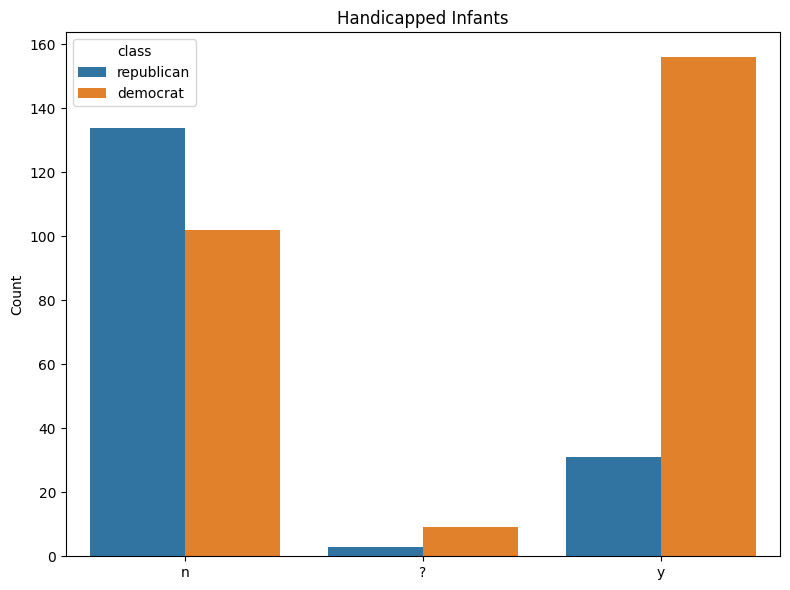

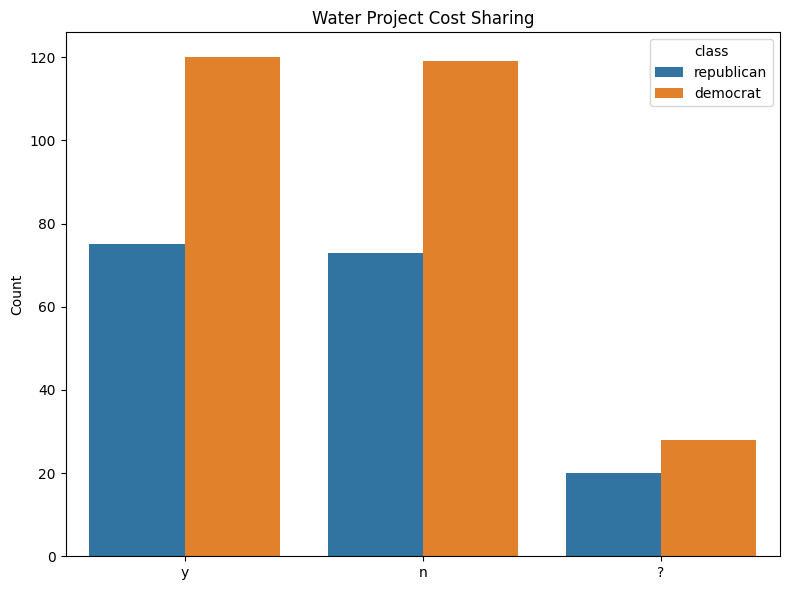

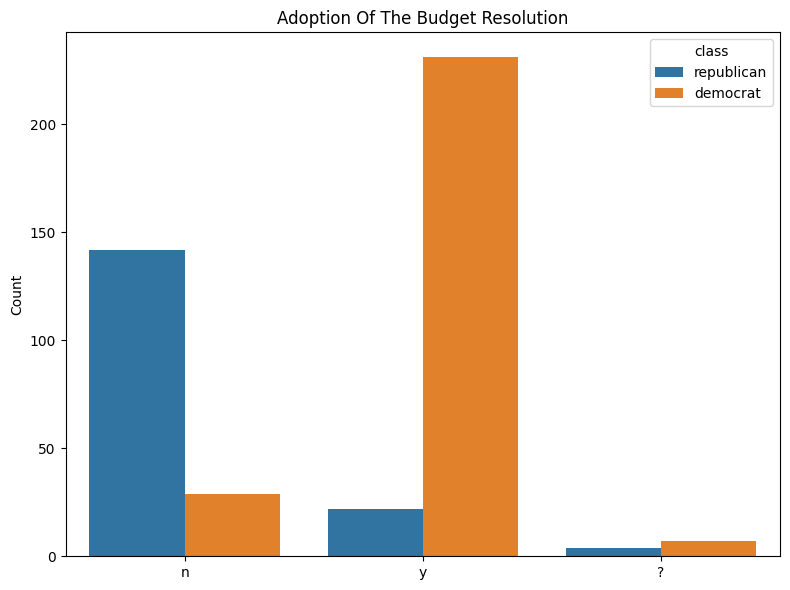

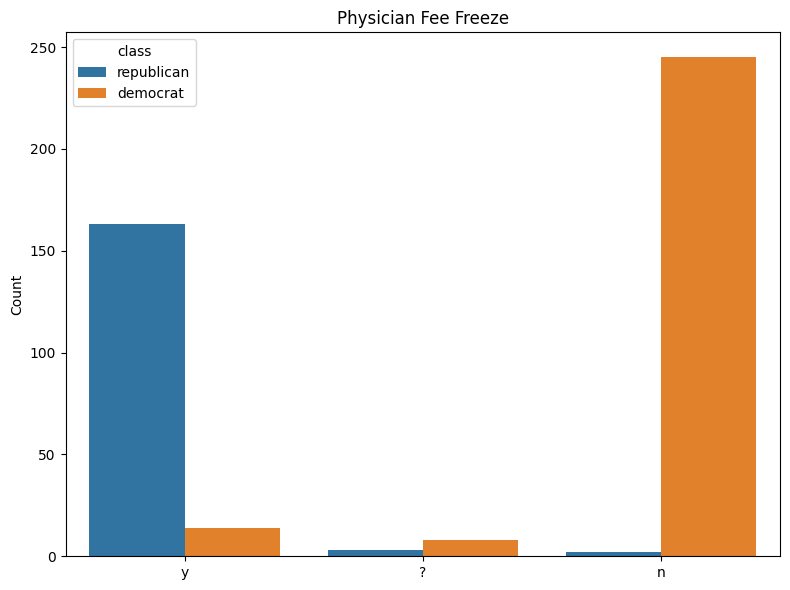

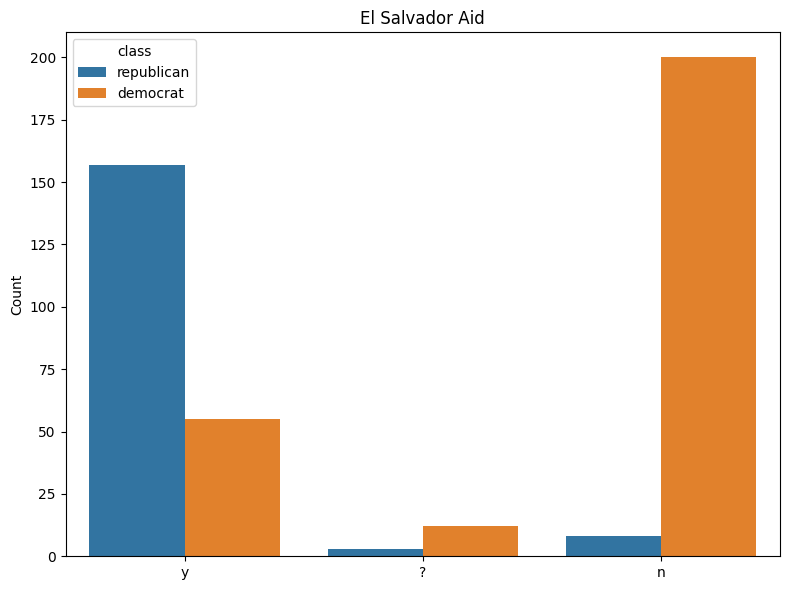

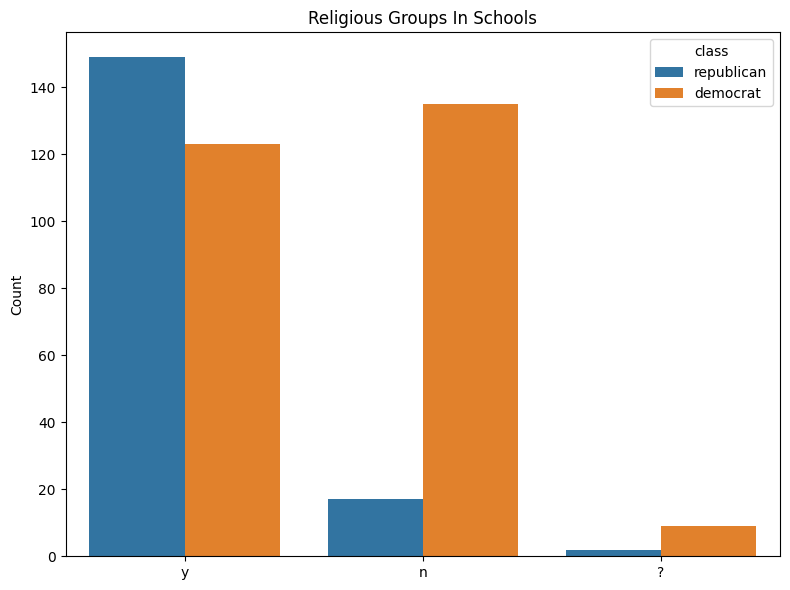

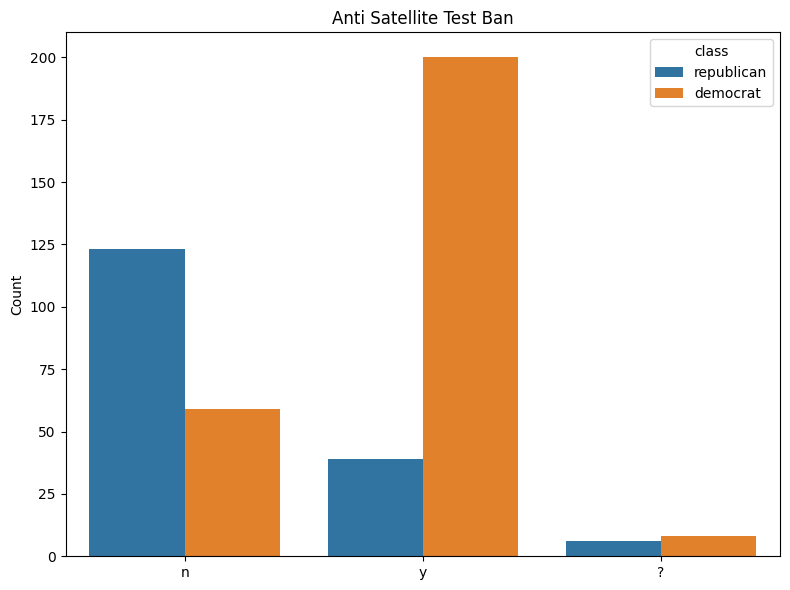

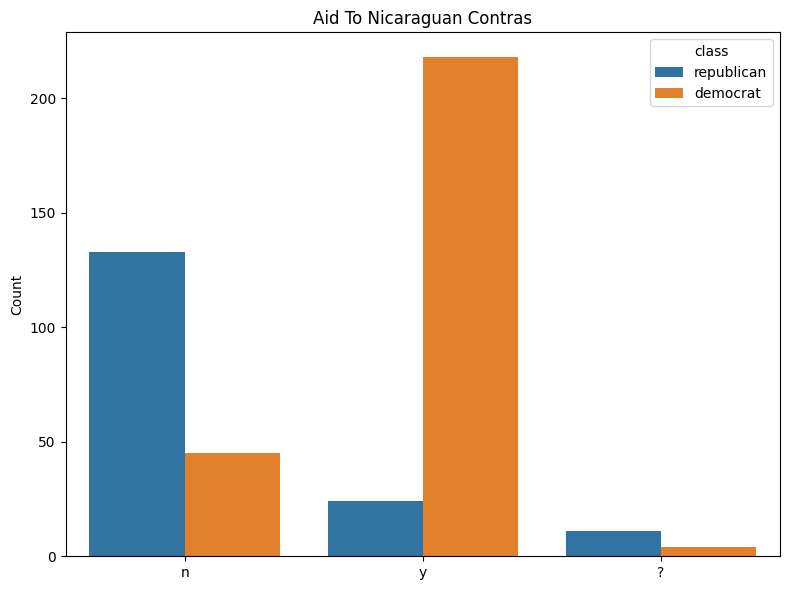

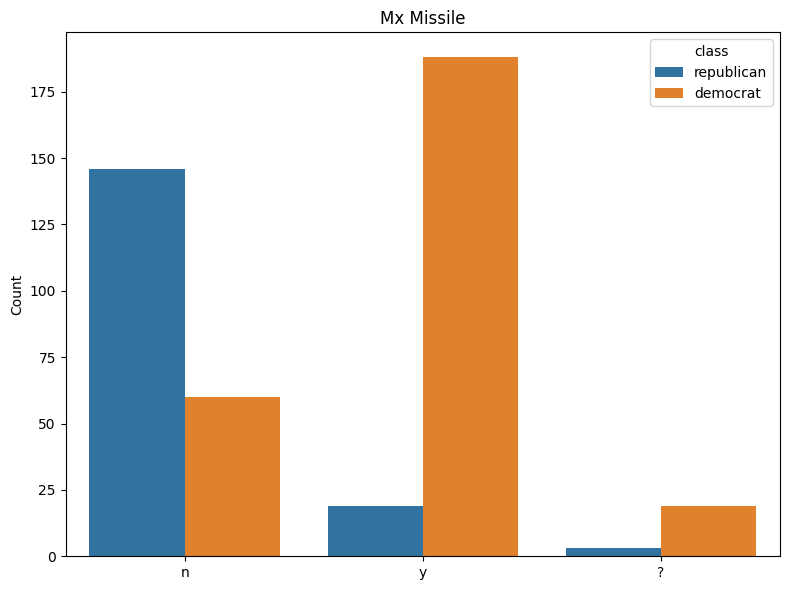

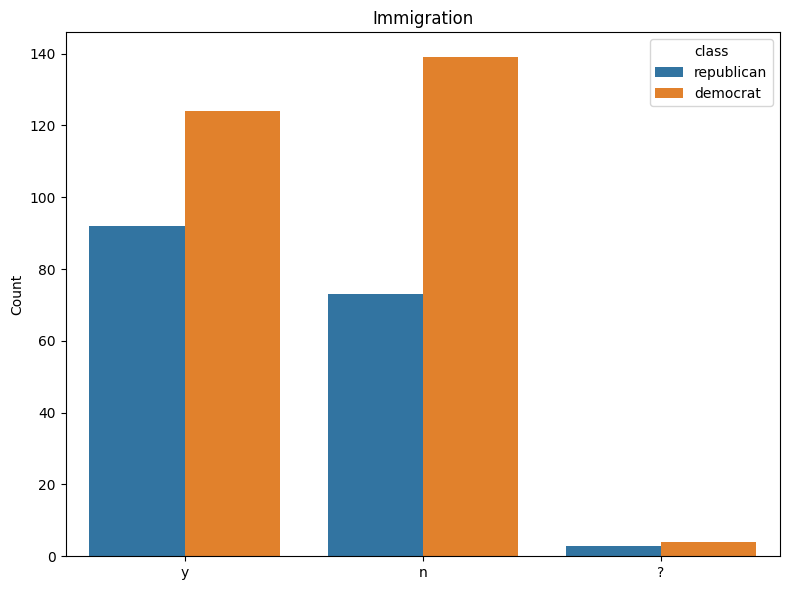

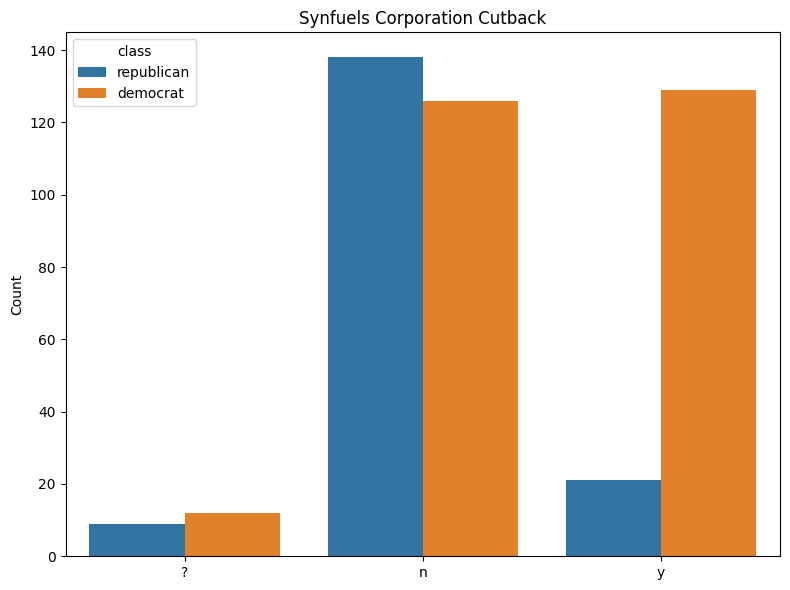

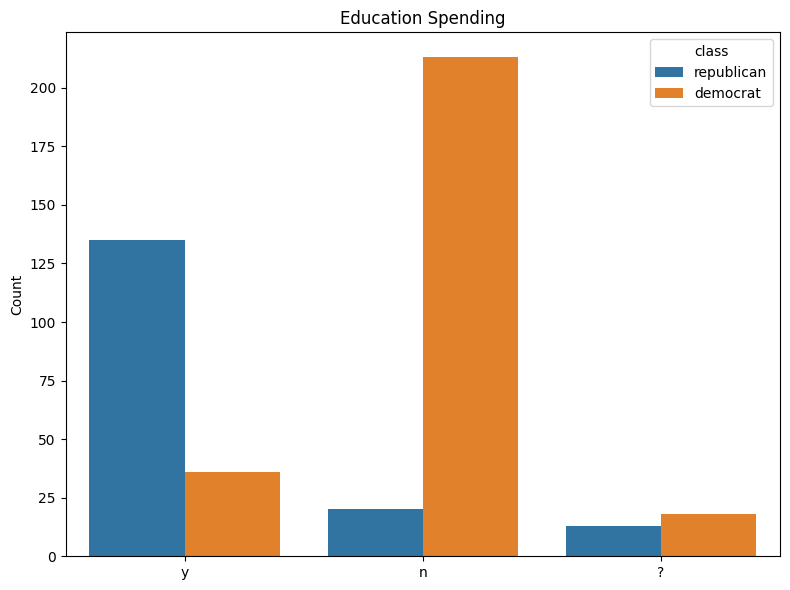

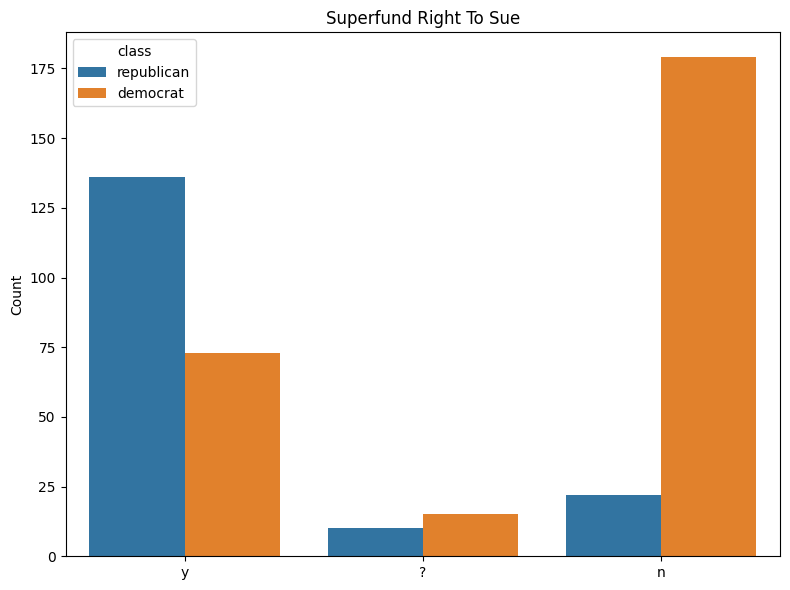

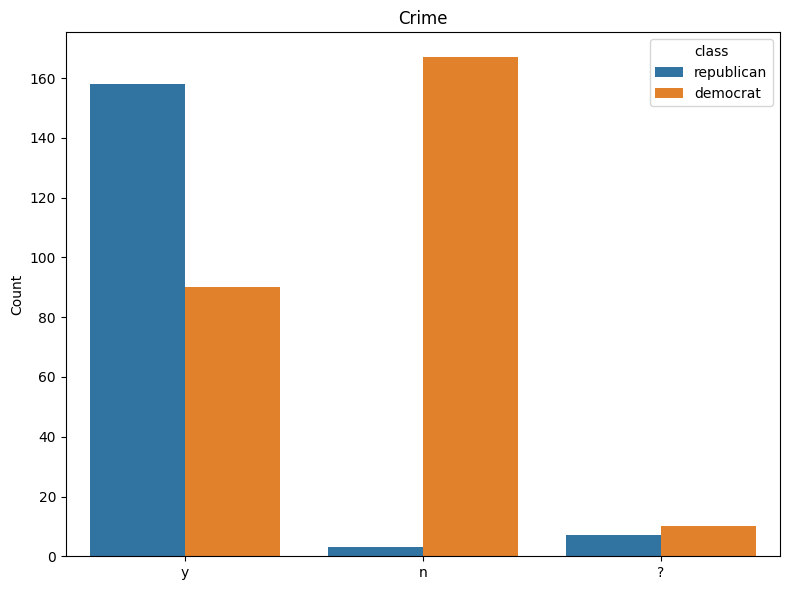

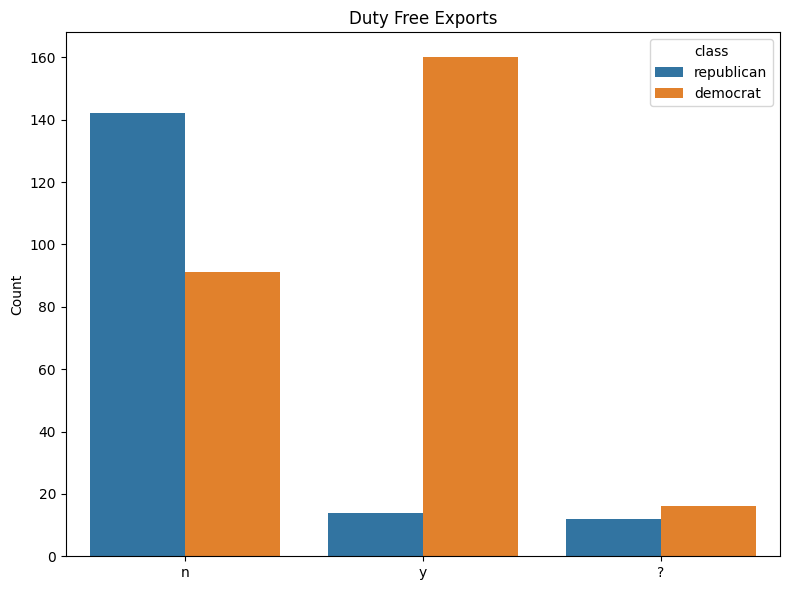

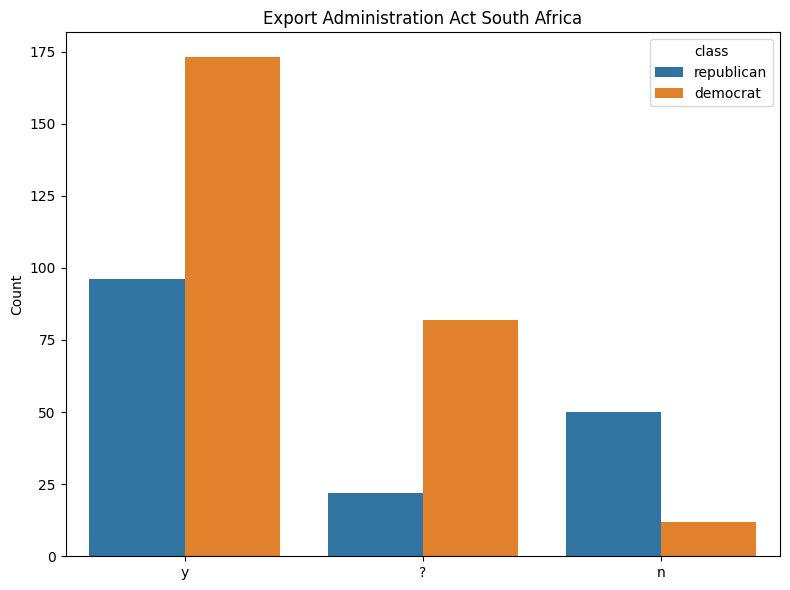

In [7]:
visualize_categorical_data(df, hue_column=target_feature, show_plot=True)

In [8]:
df = df.replace('?', pd.NA)

In [9]:
df = df.ffill(axis=0)

In [10]:
train, test = np.split(df.sample(frac=1), [int(0.7 * len(df))])

c:\Users\Oleksa\desktop\IAD-labs\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [11]:
train = pd.DataFrame(train, columns=cols)
test = pd.DataFrame(test, columns=cols)

In [12]:
model = NaiveBayes()
model.fit(train, target_feature)

In [13]:
X_test, y_test = separate_dataset(test, target_feature)

In [14]:
y_predictions = model.predict(test)
print(classification_report(y_test, y_predictions))

              precision    recall  f1-score   support

    democrat       0.97      0.93      0.95        73
  republican       0.92      0.97      0.94        58

    accuracy                           0.95       131
   macro avg       0.94      0.95      0.95       131
weighted avg       0.95      0.95      0.95       131

